In [14]:
# libraries
import numpy as np 
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler


In [15]:
# files
import os
for dirname, _, filenames in os.walk('C:/Users/16399/Downloads/ddep/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('C:/Users/16399/Downloads/ddep/data'))


C:/Users/16399/Downloads/ddep/data\data0.pickle
C:/Users/16399/Downloads/ddep/data\data1.pickle
C:/Users/16399/Downloads/ddep/data\data2.pickle
C:/Users/16399/Downloads/ddep/data\data3.pickle
C:/Users/16399/Downloads/ddep/data\data4.pickle
C:/Users/16399/Downloads/ddep/data\data5.pickle
C:/Users/16399/Downloads/ddep/data\data6.pickle
C:/Users/16399/Downloads/ddep/data\data7.pickle
C:/Users/16399/Downloads/ddep/data\data8.pickle
C:/Users/16399/Downloads/ddep/data\datasets_preparing.py
C:/Users/16399/Downloads/ddep/data\labels.pickle
C:/Users/16399/Downloads/ddep/data\label_names.csv
C:/Users/16399/Downloads/ddep/data\mean_image_gray.pickle
C:/Users/16399/Downloads/ddep/data\mean_image_rgb.pickle
C:/Users/16399/Downloads/ddep/data\std_gray.pickle
C:/Users/16399/Downloads/ddep/data\std_rgb.pickle
C:/Users/16399/Downloads/ddep/data\test.pickle
C:/Users/16399/Downloads/ddep/data\train.pickle
C:/Users/16399/Downloads/ddep/data\valid.pickle
['data0.pickle', 'data1.pickle', 'data2.pickle', 'da

In [16]:
# Opening file for reading in binary mode
with open('C:/Users/16399/Downloads/ddep/data/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


In [24]:
classes = pd.read_csv("C:/Users/16399/Downloads/ddep/data/label_names.csv") 
print(classes)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

(81, 32, 32, 3)


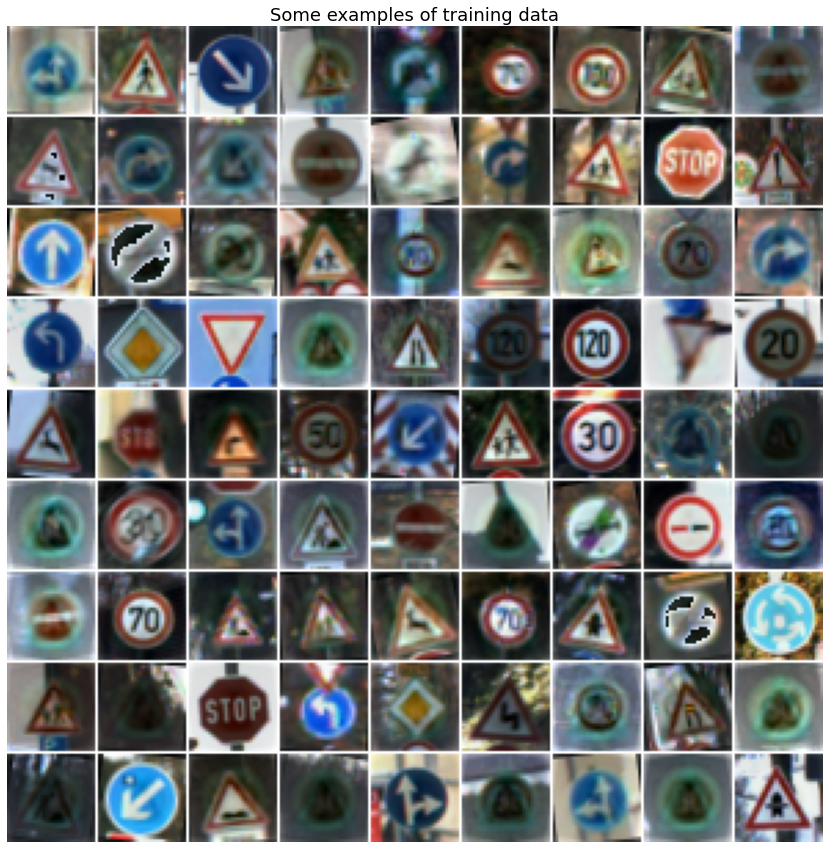

In [17]:
%matplotlib inline

# Preparing function for ploting set of examples
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

In [6]:
# initial experiment with filters
filters = [3, 5, 9, 13, 15, 19, 23, 25, 31]
model = [0] * len(filters)

for i in range(len(model)):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size=filters[i], padding='same', activation='relu', input_shape=(32, 32, 3)))
    model[i].add(MaxPool2D(pool_size=2))
    model[i].add(Flatten())
    model[i].add(Dense(500, activation='relu'))
    model[i].add(Dense(43, activation='softmax'))
    model[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 5

In [12]:
# checking accuracy of different filter size
h = [0] * len(model)

for i in range(len(h)):
    h[i] = model[i].fit(data['x_train'], data['y_train'],
                        batch_size=5, epochs = epochs,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=0)
    
    print('Model with filters {0:d}x{0:d}, epochs={1:d}, training accuracy={2:.5f}, validation accuracy={3:.5f}'.\
          format(filters[i], epochs, max(h[i].history['accuracy']), max(h[i].history['val_accuracy'])))

Model with filters 3x3, epochs=5, training accuracy=0.99331, validation accuracy=0.87256
Model with filters 5x5, epochs=5, training accuracy=0.98685, validation accuracy=0.87302
Model with filters 9x9, epochs=5, training accuracy=0.98230, validation accuracy=0.85374
Model with filters 13x13, epochs=5, training accuracy=0.97431, validation accuracy=0.83741
Model with filters 15x15, epochs=5, training accuracy=0.97092, validation accuracy=0.83333
Model with filters 19x19, epochs=5, training accuracy=0.96183, validation accuracy=0.83084
Model with filters 23x23, epochs=5, training accuracy=0.95233, validation accuracy=0.81565
Model with filters 25x25, epochs=5, training accuracy=0.95020, validation accuracy=0.82426
Model with filters 31x31, epochs=5, training accuracy=0.93776, validation accuracy=0.83628


In [72]:
# checking time classification time
for i in range(len(model)):
    start = timer()
    temp = model[i].predict(data['x_test'][:1, :, :, :])
    end = timer()
    print('data2 filter {0:d} classification time = {1:.5f}'.format(filters[i], end - start))

data2 filter 3 classification time = 0.13144
data2 filter 5 classification time = 0.13647
data2 filter 9 classification time = 0.16948
data2 filter 13 classification time = 0.14723
data2 filter 15 classification time = 0.14047
data2 filter 19 classification time = 0.15163
data2 filter 23 classification time = 0.15308
data2 filter 25 classification time = 0.14198
data2 filter 31 classification time = 0.14159


In [15]:
#creating model x(final model)
model_x = Sequential()
model_x.add(Conv2D(filters = 32,  kernel_size = (3,3), padding = "same", activation = "relu", input_shape = (32,32,3)))
model_x.add(MaxPool2D(pool_size=2))
#new convolve
model_x.add(Conv2D(filters = 32,  kernel_size = (3,3), padding = "same", activation = "relu", input_shape = (32,32,3)))
model_x.add(MaxPool2D(pool_size=2))
model_x.add(Flatten())
model_x.add(Dense(500, activation='relu'))
model_x.add(Dense(43, activation='softmax'))
model_x.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
#assigning early stopping
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor="val_loss", mode="min", patience=6)

In [17]:

h_x = model_x.fit(data['x_train'], data['y_train'],
                        batch_size=5, epochs = 250,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=1)

Epoch 1/250
17398/17398 [==============================] - 345s 20ms/step - loss: 0.8841 - accuracy: 0.7488 - val_loss: 0.4542 - val_accuracy: 0.8998
Epoch 2/250
17398/17398 [==============================] - 324s 19ms/step - loss: 0.0852 - accuracy: 0.9770 - val_loss: 0.6315 - val_accuracy: 0.8900
Epoch 3/250
17398/17398 [==============================] - 319s 18ms/step - loss: 0.0473 - accuracy: 0.9860 - val_loss: 0.6283 - val_accuracy: 0.9224
Epoch 4/250
17398/17398 [==============================] - 332s 19ms/step - loss: 0.0353 - accuracy: 0.9902 - val_loss: 0.7621 - val_accuracy: 0.9029
Epoch 5/250
17398/17398 [==============================] - 312s 18ms/step - loss: 0.0286 - accuracy: 0.9916 - val_loss: 0.8499 - val_accuracy: 0.9145
Epoch 6/250
17398/17398 [==============================] - 335s 19ms/step - loss: 0.0274 - accuracy: 0.9935 - val_loss: 0.8737 - val_accuracy: 0.9311
Epoch 7/250
17398/17398 [==============================] - 334s 19ms/step - loss: 0.0187 - accuracy:

KeyboardInterrupt: 

In [ ]:

model_x.save("deep_lx.h5")

In [36]:
#accuracy
temp = model_x.predict(data['x_test'])
temp = np.argmax(temp, axis=1)
temp = np.mean(temp == data['y_test'])
print('testing accuracy = ',(temp))

testing accuracy =  0.9210609659540776


In [34]:
#checking time
start = timer()
temp = model_x.predict(data['x_test'][:1, :, :, :])
end = timer()
print('classification time = ',(end - start))

classification time =  0.04863030000706203


In [35]:
#creating model
model_y = Sequential()
model_y.add(Conv2D(filters = 32,  kernel_size = (3,3), padding = "same", activation = "relu", input_shape = (32,32,3)))
model_y.add(MaxPool2D(pool_size=2))
#new convolve
model_y.add(Conv2D(filters = 32,  kernel_size = (3,3), padding = "same", activation = "relu", input_shape = (32,32,3)))
model_y.add(MaxPool2D(pool_size=2))
model_y.add(Flatten())
#two dense layer
model_y.add(Dense(500, activation='relu'))
model_y.add(Dense(500, activation='relu'))
model_y.add(Dense(43, activation='softmax'))
model_y.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
#assigning early stopping
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor="val_loss", mode="min", patience=6)

In [27]:
# using eraly stopping
h_y = model_y.fit(data['x_train'], data['y_train'],
                        batch_size=5, epochs = 250,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[stop], verbose=1)

Epoch 1/250
17398/17398 [==============================] - 142s 8ms/step - loss: 1.0566 - accuracy: 0.6799 - val_loss: 0.5787 - val_accuracy: 0.8556
Epoch 2/250
17398/17398 [==============================] - 141s 8ms/step - loss: 0.1371 - accuracy: 0.9612 - val_loss: 0.6786 - val_accuracy: 0.8850
Epoch 3/250
17398/17398 [==============================] - 142s 8ms/step - loss: 0.1007 - accuracy: 0.9727 - val_loss: 0.7946 - val_accuracy: 0.8721
Epoch 4/250
17398/17398 [==============================] - 142s 8ms/step - loss: 0.0894 - accuracy: 0.9767 - val_loss: 1.1792 - val_accuracy: 0.8741
Epoch 5/250
17398/17398 [==============================] - 142s 8ms/step - loss: 0.0935 - accuracy: 0.9776 - val_loss: 0.7101 - val_accuracy: 0.9075
Epoch 6/250
17398/17398 [==============================] - 140s 8ms/step - loss: 0.0885 - accuracy: 0.9813 - val_loss: 1.4722 - val_accuracy: 0.8803
Epoch 7/250
17398/17398 [==============================] - 139s 8ms/step - loss: 0.0893 - accuracy: 0.9820

In [46]:
#accuracy
temp1 = model_y.predict(data['x_test'])
temp1 = np.argmax(temp1, axis=1)
temp1 = np.mean(temp1 == data['y_test'])
print('testing accuracy = ',(temp1))

testing accuracy =  0.010134600158353128


In [43]:
#checking time
start = timer()
temp1 = model_y.predict(data['x_test'][:1, :, :, :])
end = timer()
print('classification time = ',(end - start))

classification time =  0.039772799995262176


In [78]:
model_y.summary()
model_y.save("deep_y.h5")

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 500)               1024500   
_________________________________________________________________
dense_24 (Dense)             (None, 500)             

In [48]:
#creating model
model_z = Sequential()
model_z.add(Conv2D(filters = 32,  kernel_size = (3,3), padding = "same", activation = "relu", input_shape = (32,32,3)))
model_z.add(MaxPool2D(pool_size=2))
#new convolve
model_z.add(Conv2D(filters = 32,  kernel_size = (3,3), padding = "same", activation = "relu", input_shape = (32,32,3)))
model_z.add(MaxPool2D(pool_size=2))
model_z.add(Flatten())
#two dense layer
model_z.add(Dense(500, activation='relu'))
model_z.add(Dense(500, activation='relu'))
model_z.add(Dense(43, activation='softmax'))
model_z.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# without early stopping
h_z = model_z.fit(data['x_train'], data['y_train'],
                        batch_size=32, epochs = 250,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=1)

Epoch 1/250
2719/2719 [==============================] - 56s 20ms/step - loss: 1.2608 - accuracy: 0.6441 - val_loss: 0.4306 - val_accuracy: 0.8667
Epoch 2/250
2719/2719 [==============================] - 53s 20ms/step - loss: 0.0881 - accuracy: 0.9746 - val_loss: 0.3570 - val_accuracy: 0.8995
Epoch 3/250
2719/2719 [==============================] - 51s 19ms/step - loss: 0.0500 - accuracy: 0.9854 - val_loss: 0.3959 - val_accuracy: 0.9147
Epoch 4/250
2719/2719 [==============================] - 53s 19ms/step - loss: 0.0304 - accuracy: 0.9906 - val_loss: 0.4875 - val_accuracy: 0.9107
Epoch 5/250
2719/2719 [==============================] - 53s 20ms/step - loss: 0.0261 - accuracy: 0.9921 - val_loss: 0.4777 - val_accuracy: 0.9186
Epoch 6/250
2719/2719 [==============================] - 56s 21ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 0.5268 - val_accuracy: 0.9020
Epoch 7/250
2719/2719 [==============================] - 56s 21ms/step - loss: 0.0178 - accuracy: 0.9947 - val_loss: 0

Epoch 109/250
2719/2719 [==============================] - 53s 19ms/step - loss: 9.8653e-11 - accuracy: 1.0000 - val_loss: 0.8317 - val_accuracy: 0.9442
Epoch 110/250
2719/2719 [==============================] - 52s 19ms/step - loss: 1.2182e-10 - accuracy: 1.0000 - val_loss: 0.8317 - val_accuracy: 0.9442
Epoch 111/250
2719/2719 [==============================] - 53s 19ms/step - loss: 1.0491e-10 - accuracy: 1.0000 - val_loss: 0.8317 - val_accuracy: 0.9442
Epoch 112/250
2719/2719 [==============================] - 53s 19ms/step - loss: 1.1911e-10 - accuracy: 1.0000 - val_loss: 0.8318 - val_accuracy: 0.9442
Epoch 113/250
2719/2719 [==============================] - 53s 19ms/step - loss: 9.4583e-11 - accuracy: 1.0000 - val_loss: 0.8317 - val_accuracy: 0.9442
Epoch 114/250
2719/2719 [==============================] - 53s 19ms/step - loss: 1.1361e-10 - accuracy: 1.0000 - val_loss: 0.8317 - val_accuracy: 0.9442
Epoch 115/250
2719/2719 [==============================] - 53s 19ms/step - loss: 1

2719/2719 [==============================] - 52s 19ms/step - loss: 9.5420e-11 - accuracy: 1.0000 - val_loss: 0.8319 - val_accuracy: 0.9442
Epoch 216/250
2719/2719 [==============================] - 53s 19ms/step - loss: 8.8164e-11 - accuracy: 1.0000 - val_loss: 0.8319 - val_accuracy: 0.9442
Epoch 217/250
2719/2719 [==============================] - 53s 19ms/step - loss: 1.1487e-10 - accuracy: 1.0000 - val_loss: 0.8319 - val_accuracy: 0.9442
Epoch 218/250
2719/2719 [==============================] - 53s 19ms/step - loss: 1.4199e-10 - accuracy: 1.0000 - val_loss: 0.8319 - val_accuracy: 0.9442
Epoch 219/250
2719/2719 [==============================] - 53s 19ms/step - loss: 9.5750e-11 - accuracy: 1.0000 - val_loss: 0.8319 - val_accuracy: 0.9442
Epoch 220/250
2719/2719 [==============================] - 54s 20ms/step - loss: 1.1342e-10 - accuracy: 1.0000 - val_loss: 0.8319 - val_accuracy: 0.9442
Epoch 221/250
2719/2719 [==============================] - 53s 20ms/step - loss: 7.6696e-11 - ac

In [79]:
model_z.save("deep_z.h5")

In [51]:
#accuracy
temp2 = model_y.predict(data['x_test'])
temp2 = np.argmax(temp2, axis=1)
temp2 = np.mean(temp2 == data['y_test'])
print('testing accuracy = ',(temp2))

testing accuracy =  0.010134600158353128


In [52]:
#checking time
start = timer()
temp2 = model_y.predict(data['x_test'][:1, :, :, :])
end = timer()
print('classification time = ',(end - start))

classification time =  0.042782000004081056


In [60]:
#initial model
model_a = Sequential()
model_a.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model_a.add(MaxPool2D(pool_size=2))
model_a.add(Flatten())
model_a.add(Dense(500, activation='relu'))
model_a.add(Dense(43, activation='softmax'))
model_a.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
h_a = model_a.fit(data['x_train'], data['y_train'],
                        batch_size=32, epochs = 250,
                        validation_data = (data['x_validation'], data['y_validation']),
                        callbacks=[annealer], verbose=1)

Epoch 1/250
2719/2719 [==============================] - 72s 26ms/step - loss: 1.1748 - accuracy: 0.6930 - val_loss: 0.5325 - val_accuracy: 0.8399
Epoch 2/250
2719/2719 [==============================] - 66s 24ms/step - loss: 0.1298 - accuracy: 0.9667 - val_loss: 0.5680 - val_accuracy: 0.8639
Epoch 3/250
2719/2719 [==============================] - 65s 24ms/step - loss: 0.0708 - accuracy: 0.9817 - val_loss: 0.5320 - val_accuracy: 0.8853
Epoch 4/250
2719/2719 [==============================] - 65s 24ms/step - loss: 0.0426 - accuracy: 0.9887 - val_loss: 0.6585 - val_accuracy: 0.8957
Epoch 5/250
2719/2719 [==============================] - 65s 24ms/step - loss: 0.0322 - accuracy: 0.9909 - val_loss: 0.7158 - val_accuracy: 0.8816
Epoch 6/250
2719/2719 [==============================] - 64s 24ms/step - loss: 0.0245 - accuracy: 0.9933 - val_loss: 0.6527 - val_accuracy: 0.8950
Epoch 7/250
2719/2719 [==============================] - 65s 24ms/step - loss: 0.0189 - accuracy: 0.9946 - val_loss: 1

2719/2719 [==============================] - 65s 24ms/step - loss: 3.3557e-07 - accuracy: 1.0000 - val_loss: 1.4445 - val_accuracy: 0.9152
Epoch 109/250
2719/2719 [==============================] - 66s 24ms/step - loss: 3.2574e-07 - accuracy: 1.0000 - val_loss: 1.4451 - val_accuracy: 0.9152
Epoch 110/250
2719/2719 [==============================] - 66s 24ms/step - loss: 3.5053e-07 - accuracy: 1.0000 - val_loss: 1.4458 - val_accuracy: 0.9150
Epoch 111/250
2719/2719 [==============================] - 65s 24ms/step - loss: 3.2074e-07 - accuracy: 1.0000 - val_loss: 1.4468 - val_accuracy: 0.9152
Epoch 112/250
2719/2719 [==============================] - 65s 24ms/step - loss: 3.7574e-07 - accuracy: 1.0000 - val_loss: 1.4469 - val_accuracy: 0.9150
Epoch 113/250
2719/2719 [==============================] - 66s 24ms/step - loss: 3.2302e-07 - accuracy: 1.0000 - val_loss: 1.4473 - val_accuracy: 0.9154
Epoch 114/250
2719/2719 [==============================] - 66s 24ms/step - loss: 3.1156e-07 - ac

2719/2719 [==============================] - 66s 24ms/step - loss: 3.0732e-07 - accuracy: 1.0000 - val_loss: 1.4553 - val_accuracy: 0.9150
Epoch 215/250
2719/2719 [==============================] - 66s 24ms/step - loss: 2.8383e-07 - accuracy: 1.0000 - val_loss: 1.4553 - val_accuracy: 0.9150
Epoch 216/250
2719/2719 [==============================] - 65s 24ms/step - loss: 2.7978e-07 - accuracy: 1.0000 - val_loss: 1.4553 - val_accuracy: 0.9150
Epoch 217/250
2719/2719 [==============================] - 65s 24ms/step - loss: 3.0055e-07 - accuracy: 1.0000 - val_loss: 1.4553 - val_accuracy: 0.9150
Epoch 218/250
2719/2719 [==============================] - 65s 24ms/step - loss: 2.9967e-07 - accuracy: 1.0000 - val_loss: 1.4553 - val_accuracy: 0.9150
Epoch 219/250
2719/2719 [==============================] - 66s 24ms/step - loss: 2.8882e-07 - accuracy: 1.0000 - val_loss: 1.4553 - val_accuracy: 0.9150
Epoch 220/250
2719/2719 [==============================] - 66s 24ms/step - loss: 2.8603e-07 - ac

In [80]:
model_a.save("deep_a.h5")

In [63]:
#accuracy
temp3 = model_a.predict(data['x_test'])
temp3 = np.argmax(temp3, axis=1)
temp3 = np.mean(temp3 == data['y_test'])
print('testing accuracy = ',(temp3))

testing accuracy =  0.9024544734758512


In [64]:
#checking time
start = timer()
temp2 = model_a.predict(data['x_test'][:1, :, :, :])
end = timer()
print('classification time = ',(end - start))

classification time =  0.0589693000074476


(3, 3, 3, 32)
(32, 3, 3, 3)


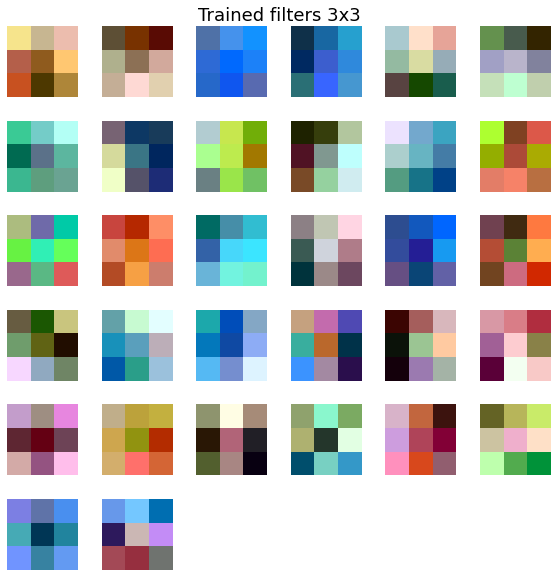

In [81]:
#for final model
w = model_x.get_weights()
print(w[0].shape)

# Visualizing filters
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  

# Plotting
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
name = 'Trained filters 3x3'
plt.title(name, fontsize=18)

# Showing the plot
plt.show()


In [18]:
from tensorflow import keras
model_i= keras.models.load_model("deep_x.h5")

In [19]:
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


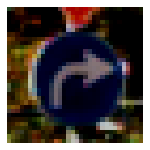

ClassId: 33
Label: Turn right ahead


In [27]:
i = random.randint(0,101)
# Preparing image for predicting from test dataset
x_input = data['x_test'][i:101]
#print(x_input.shape)
y_input = data['y_test'][i:101]
#print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
plt.show()

# Getting scores from forward pass of input image
#model name
scores = model_i.predict(x_input)
# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('C:/Users/16399/Downloads/ddep/data/label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])